In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

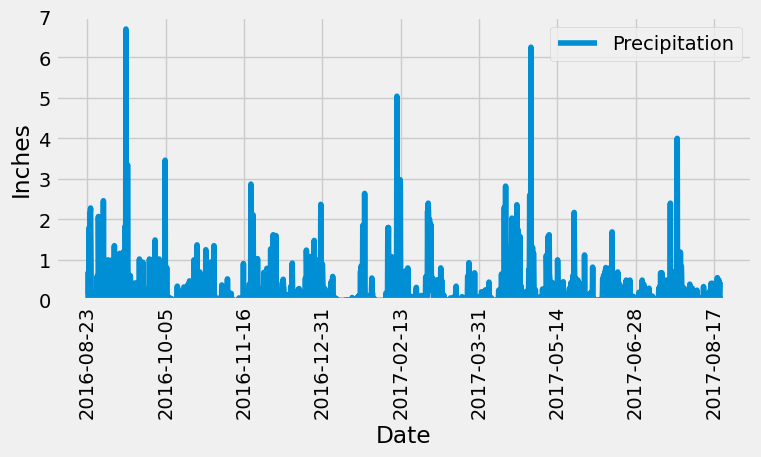

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores and sort by date
# Not used to follow the instructions explicitly for sorting after the data is in a dataframe
# precip_12mo = session.query(measurement.date, measurement.prcp).filter(measurement.date>=year_ago).order_by(measurement.date).all()

# Perform a query to retrieve the date and precipitation scores not sorted
precip_12mo = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date>=year_ago).\
    filter(measurement.prcp!="NaN").all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_12mo_df = pd.DataFrame(precip_12mo, columns=["Date", "Precipitation"])

# Sort the dataframe by date
precip_12mo_df = precip_12mo_df.sort_values(by=["Date"]).reset_index()

# Use Pandas Plotting with Matplotlib to plot the data
precip_12mo_df.plot(figsize=(8,3.5), rot="vertical",
                    x="Date", y="Precipitation")
plt.ylabel("Inches")
plt.ylim(0,7)
plt.tight_layout
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Reference pulling in quartiles to the aggregate example from Stack Overflow: 
# https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = '{:02.0f}%'.format(n*100)
    return percentile_

summ_stats = precip_12mo_df["Precipitation"].agg(func=["count", "mean", "std", "min", 
                                                       percentile(0.25), percentile(0.50), 
                                                       percentile(0.75), "max"])
summ_stats.to_frame()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_cnt = session.query(measurement.station).distinct().count()
station_cnt

9

In [13]:
session.query(measurement.station, func.count(measurement.id)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, 
# calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), 
              func.max(measurement.tobs), 
              func.avg(measurement.tobs)).\
            filter(measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

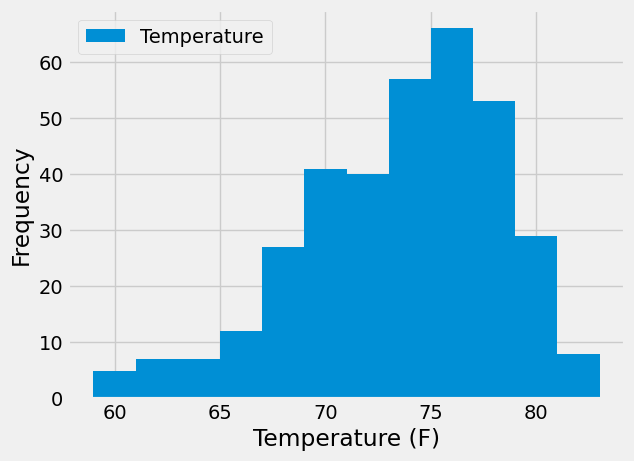

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
# and plot the results as a histogram

# Perform a query to retrieve the temperature for the last year of station USC00519281
USC00519281_12mo_temp = session.query(measurement.tobs).\
    filter(measurement.date>=year_ago).\
    filter(measurement.station=='USC00519281').\
    filter(measurement.tobs!="NaN").all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
USC00519281_12mo_temp_df = pd.DataFrame(USC00519281_12mo_temp, columns=["Temperature"])

# Use pandas histogram plot
ax = USC00519281_12mo_temp_df.plot.hist(bins=12)
ax.set_xlabel("Temperature (F)")
plt.show()

# Close Session

In [16]:
# Close Session
session.close()